In [143]:
from env import *
from env_tradestation import *
from data_retriever_simple import Client
import acquire
import prepare

import cbpro
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns

import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, MinMaxScaler, RobustScaler
from sklearn.feature_selection import RFE, SelectKBest

import warnings
warnings.filterwarnings("ignore")

Basis for much of this: https://jfin-swufe.springeropen.com/track/pdf/10.1186/s40854-020-00217-x.pdf

# Personal Project - Compare the ability to predict cryptocurrency closing prices using machine learning and ARIMA models

## Start with acquiring crypto data
- Will acquire Bitcoin, Ethereum, and Litecoin data as these have some of the longest price histories and greatest liquidity

In [107]:
adfuller(train.fwd_log_ret)

(-11.740553531103322,
 1.2767395188250911e-21,
 5,
 1027,
 {'1%': -3.4367333690404767,
  '5%': -2.8643583648001925,
  '10%': -2.568270618452702},
 -3518.490358134669)

In [2]:
desired_products = ['BTC-USD',
 'ETH-USD',
 'LTC-USD']

In [3]:
results = acquire.get_data_from_csv()

In [4]:
prepared_results = prepare.prepare_crypto_data(results)

Max first date is 2016-08-17 00:00:00, starting all dataframes at this day
Corrected btc low data for 2017-04-15


### First iteration only using BTC

In [5]:
btc=prepared_results['BTC_USD']

In [6]:
btc.isna().sum()

time      0
low       0
high      0
open      0
close     0
volume    0
dtype: int64

No nulls

In [7]:
btc.describe()

,low,high,open,close,volume
count,2075.000000,2075.000000,2075.000000,2075.000000,2075.000000
mean,15367.271296,16353.665287,15891.738578,15910.606708,14627.887462
std,16901.301024,17955.831798,17468.665539,17473.333789,11638.656327
min,568.120000,573.310000,570.830000,570.840000,683.798071
25%,4082.865000,4365.630000,4249.675000,4258.360000,7144.589967
50%,8215.660000,8760.430000,8522.300000,8525.070000,11718.880202
75%,17445.630000,18601.875000,17830.325000,17940.440000,18296.256136
max,66261.790000,69000.000000,67554.130000,67554.840000,130316.646844


Min btc value of 0.06 is suspicious and should be corrected

In [8]:
# Incorporated into prepare
# btc.index[btc.low == 0.06]

# Gather minute data from that day to fix the low value
# minute_data = acquire.acquire_crypto_data(acquire.get_full_product_info(['BTC-USD']),datetime(2017, 4, 15, 0,0,0), datetime(2017, 4, 15, 23, 59, 0), 60)

# minute_data['BTC-USD']=minute_data['BTC-USD'].loc[(minute_data['BTC-USD'].index<'2017-04-15 23:00:00' )|(minute_data['BTC-USD'].index>'2017-04-15 23:50:00')]

# minute_data['BTC-USD'].low.min()

# btc.loc['2017-04-15','low'] = minute_data['BTC-USD'].low.min()

In [9]:
# auth_client = cbpro.AuthenticatedClient(api_key, secret_key, passphrase)

In [10]:
# desired_products_with_info = acquire.get_full_product_info(desired_products)

In [11]:
# results = acquire.acquire_crypto_data(desired_products_with_info, datetime.now()-timedelta(days=3000), datetime.now(), minute_bars=86400)

Text(0.5, 1.0, 'Bitcoin data starts earliest')

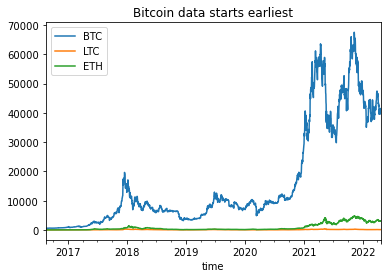

In [12]:
results['BTC_USD'].close.plot(label='BTC')
results['LTC_USD'].close.plot(label='LTC')
results['ETH_USD'].close.plot(label='ETH')
plt.legend()
plt.title('Bitcoin data starts earliest')

In [13]:
print('Min data bitcoin: ',results['BTC_USD'].index.min())
print('Min data litecoin: ',results['LTC_USD'].index.min())
print('Min data ethereum: ',results['ETH_USD'].index.min())

Min data bitcoin:  2016-08-17 00:00:00
Min data litecoin:  2016-08-17 00:00:00
Min data ethereum:  2016-08-17 00:00:00


Will truncate data so all starts at same day

### Volatility:
- relative price range: RR
- range volatility estimator of Parkinson: sigma  - lags 1-7

#### Lagged log returns, 1-7 days earlier

In [14]:
btc = prepare.add_features(btc)

## Add target and features (all added to prepare.py file)

In [15]:
# # forward 1 day log returns
# btc["log_ret_fwd"] = np.log(btc.close) - np.log(btc.close.shift(-1))
# # forward standard returns
# btc["ret_fwd"] = btc.close.shift(-1) - btc.close
# btc["pct_chg"] = btc.close.pct_change()

In [16]:
# for i in range(1,8):
#     btc[f'log_ret_lag_{i}'] = np.log(df.close) - np.log(df.close.shift(i))

## Split data

In [17]:
train_size = int(len(btc) * .5)
validate_size = int(len(btc) * .3)
test_size = int(len(btc) - train_size - validate_size)
validate_end_index = train_size + validate_size

# split into train, validation, test
train = btc[: train_size]
validate = btc[train_size : validate_end_index]
test = btc[validate_end_index : ]

### Get summary statistics for each dataset

In [18]:
summary_df = pd.DataFrame()
def get_summary_statistics(df, target, index_name):
    return pd.concat([summary_df,pd.DataFrame(data={'mean':df[target].mean()*100,
                              'median':df[target].median()*100,
                              'min':df[target].min()*100,
                              'max':df[target].max()*100,
                              'std':df[target].std()*100,
                              'iqr':stats.iqr(df[target]),
                              'skewness':stats.skew(df[target]),
                              'excess_kurtosis':stats.kurtosis(df[target],fisher=True),
                              'autocorrelation':sm.tsa.acf(df[target], nlags=1)[1],
                                                   'start_sample_date': df.index.min(),
                                                   'end_sample_date': df.index.max()}, index = [index_name])])

In [19]:
get_summary_statistics(train, 'fwd_log_ret','btc_train')

,mean,median,min,max,std,iqr,skewness,excess_kurtosis,autocorrelation,start_sample_date,end_sample_date
btc_train,-0.283637,-0.311017,-24.060603,17.067595,4.19351,0.033026,-0.05367,3.710479,-0.01151,2016-08-24,2019-06-22


In [20]:
get_summary_statistics(validate, 'fwd_log_ret','btc_validate')

,mean,median,min,max,std,iqr,skewness,excess_kurtosis,autocorrelation,start_sample_date,end_sample_date
btc_validate,-0.241331,-0.192699,-17.807628,49.12261,4.280663,0.035989,2.286196,29.250919,-0.130142,2019-06-23,2021-03-03


In [21]:
get_summary_statistics(test, 'fwd_log_ret','btc_test')

,mean,median,min,max,std,iqr,skewness,excess_kurtosis,autocorrelation,start_sample_date,end_sample_date
btc_test,0.047526,-0.020542,-13.555753,15.423099,3.79929,0.042522,0.163279,1.665123,-0.051122,2021-03-04,2022-04-21


### Some differences in descriptive statistics for each split of BTC data:
- Train and validate have similar negative mean return
- All sets have large double digit min and max log returns
- All sets have fairly high standard deviations and iqr, showing the volatility of this currency


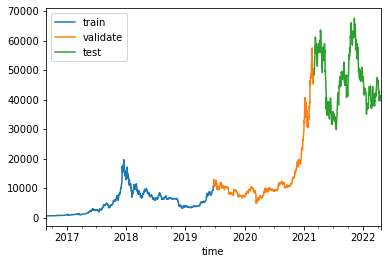

In [22]:
train.close.plot(label='train')
validate.close.plot(label='validate')
test.close.plot(label='test')
plt.legend()

### Differences in split samples:
- Both train and validate include a huge runup, though only train has a large crash afterward
- Test includes a crash from highs in 2021 followed by new all time highs later in the year followed by another crash

### Target exploration:
- primary regression target is forward log returns, which is the difference in close from tomorrow to today
- classification target is whether next close is positive
- returns used (vs absolute prices) so can compare between different time series
- if assume prices are distributed log normally then log 

<AxesSubplot:>

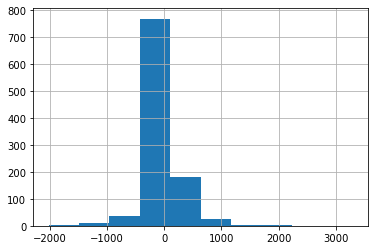

In [23]:
train.fwd_ret.hist()

Text(0.5, 1.0, 'Log returns used because assumed returns follow a log normal distribution\nLog returns are also additive to allow for compounding easily')

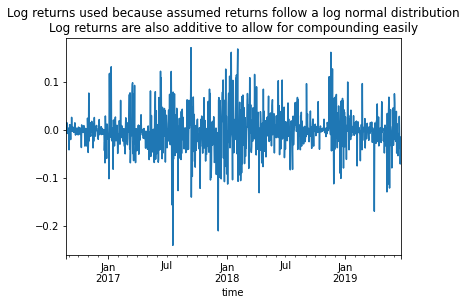

In [24]:
train.fwd_log_ret.plot()
plt.title('Log returns used because assumed returns follow a log normal distribution\nLog returns are also additive to allow for compounding easily')

Text(0.5, 1.0, 'More Normal Looking')

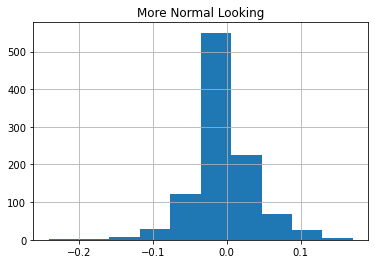

In [25]:
train.fwd_log_ret.hist()
plt.title('More Normal Looking')

<AxesSubplot:xlabel='time'>

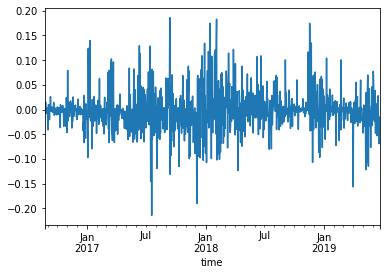

In [26]:
train.fwd_pct_chg.plot()

Text(0.5, 1.0, 'Next Close Positive - fairly balanced')

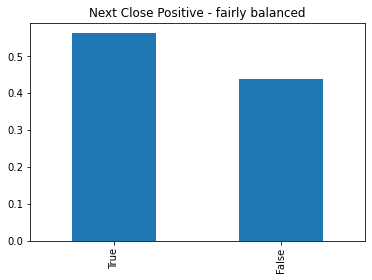

In [27]:
train.fwd_close_positive.value_counts(normalize=True).plot.bar()
plt.title('Next Close Positive - fairly balanced')

### Are there any differences in log returns based on the day of the week or the month of the year?
- Because this is looking at forward log returns it is actually looking at the following day's return

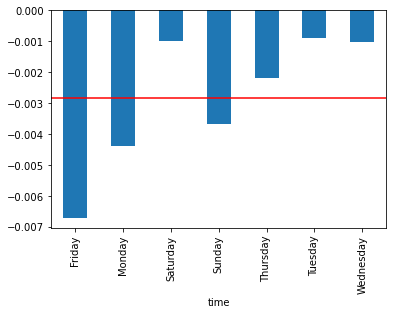

In [28]:
train.groupby(train.index.day_name()).fwd_log_ret.mean().plot.bar()
plt.axhline(train.fwd_log_ret.mean(), color = 'r')

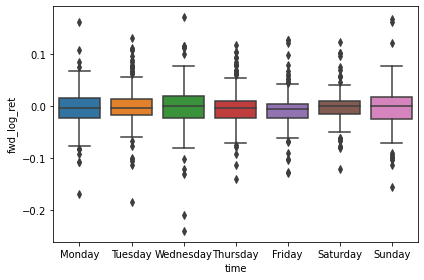

In [29]:
sns.boxplot(x=train.index.day_name(), y = train.fwd_log_ret, order=['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'])
plt.tight_layout()

In [30]:
# Set alpha to 0.05
alpha = 0.05
overall_mean = train.fwd_log_ret.mean()
for day_of_the_week in train.index.day_name().unique():
    sample = train[train.index.day_name() == day_of_the_week]
    t,p=stats.ttest_1samp(sample.fwd_log_ret, overall_mean)
    print(day_of_the_week, t, p<alpha)

Wednesday 0.4382109049371638 False
Thursday 0.19071391435173793 False
Friday -1.2220108640716778 False
Saturday 0.6757647160605057 False
Sunday -0.22803172561984486 False
Monday -0.45829650036842684 False
Tuesday 0.5432212034679261 False


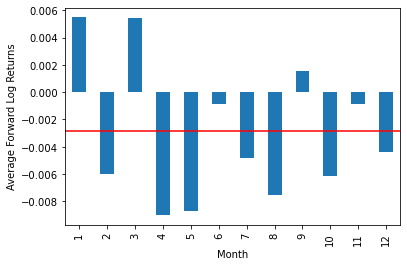

In [31]:
train.groupby(train.index.month).fwd_log_ret.mean().plot.bar()
plt.axhline(train.fwd_log_ret.mean(), color = 'r')
plt.xlabel('Month')
plt.ylabel('Average Forward Log Returns')
None

In [32]:
overall_mean = train.fwd_log_ret.mean()
for month_of_year in train.index.month.unique():
    sample = train[train.index.month == month_of_year]
    t,p=stats.ttest_1samp(sample.fwd_log_ret, overall_mean)
    print(month_of_year, t, p<alpha)

8 -1.2273269594973495 False
9 1.1243058735938383 False
10 -1.3046282286404267 False
11 0.4214624142362868 False
12 -0.2842678944628774 False
1 1.636415104926473 False
2 -0.6457455426399578 False
3 2.0085106074230747 True
4 -1.6800486284375764 False
5 -1.4088257328256801 False
6 0.4410689548599772 False
7 -0.29825054760730546 False


### Takeaways:
- All days exhibit negative log returns for the next day on average
- There is wide variation depending on the day of the week though, suggesting day of the week matters when it comes to predicting returns
- No day's returns are statistically different from the overall mean
- Wednesday and Sunday have the widest spread in values, suggesting Monday and Thursday are some of the more volatile days of the week
- No month except March exhibits average returns significantly different from the overal mean

### Take a look at correlations - not very relevant given time series

In [33]:
# Everything besides encoding day name columns
train[[col for col in train.columns if 'day_name' not in col]].corrwith(train.fwd_log_ret).sort_values(ascending=False)

fwd_log_ret           1.000000
fwd_pct_chg           0.998780
open                  0.068015
low                   0.066747
high                  0.066128
close                 0.065933
sigma_lag_5           0.039582
sigma_lag_4           0.016418
pct_chg               0.012351
log_ret_lag_1         0.011469
log_ret_lag_4        -0.005556
sigma_lag_3          -0.012200
sigma_lag_7          -0.015279
sigma_lag_1          -0.018403
RR                   -0.018527
log_ret_lag_2        -0.020126
volume               -0.031338
log_ret_lag_3        -0.031387
log_ret_lag_7        -0.036887
log_ret_lag_5        -0.037157
sigma_lag_2          -0.045426
sigma_lag_6          -0.047553
log_ret_lag_6        -0.049871
fwd_close_positive   -0.667871
fwd_ret              -0.827821
dtype: float64

### Visualize target over time

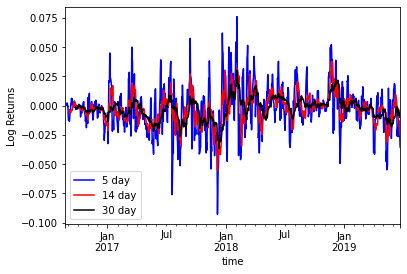

In [34]:
train.fwd_log_ret.rolling(5).mean().plot(label = '5 day',color = 'blue')
train.fwd_log_ret.rolling(14).mean().plot(label = '14 day',color = 'r')
train.fwd_log_ret.rolling(30).mean().plot(label = '30 day',color = 'black')
plt.ylabel('Log Returns')
plt.legend()

### Seasonal plot

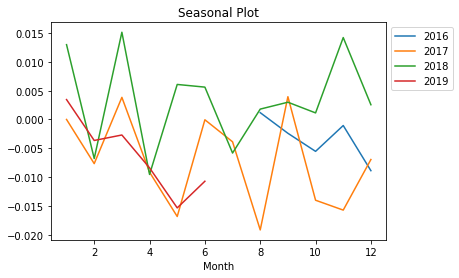

In [35]:
train.fwd_log_ret.groupby([train.index.year, train.index.month]).mean().unstack(0).plot(title='Seasonal Plot')
plt.xlabel("Month")
plt.legend(bbox_to_anchor=(1, 1))

### Takeaways:
- Every March there appears to be a big jump positive in returns, followed by big dip in April
- No other months appear to show seasonality

### Lag plot of log returns

Text(0.5, 1.0, '1 day lag plot of log returns\nNo obvious relationship observed')

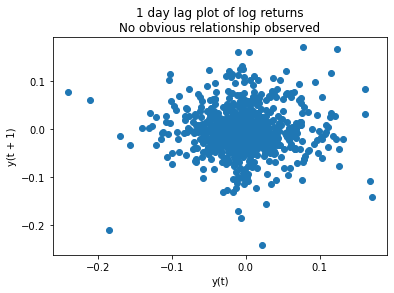

In [36]:
pd.plotting.lag_plot(train.fwd_log_ret, lag = 1)
plt.title('1 day lag plot of log returns\nNo obvious relationship observed')

Text(0.5, 1.0, '1 day lag plot of close price\nDefinitely a linear looking relationship')

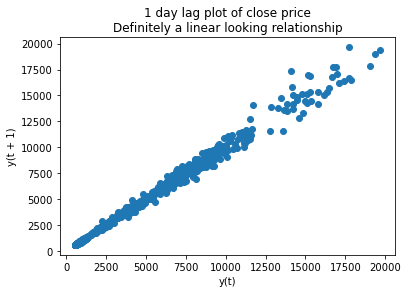

In [37]:
pd.plotting.lag_plot(train.close, lag = 1)
plt.title('1 day lag plot of close price\nDefinitely a linear looking relationship')

### Autocorrelation of daily close - highest correlations with lags < 50

Text(0.5, 1.0, 'No real seasonality evident')

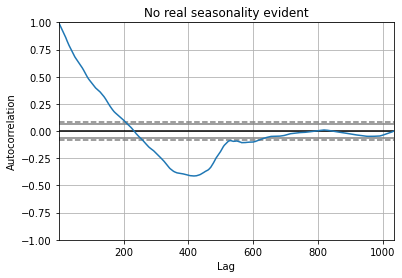

In [38]:
pd.plotting.autocorrelation_plot(train.close)
plt.title('No real seasonality evident')

### Seasonal decomposition

In [39]:
result = sm.tsa.seasonal_decompose(train.fwd_log_ret)
decomposition = pd.DataFrame({
    'y': result.observed,
    'trend': result.trend,
    'seasonal': result.seasonal,
    'resid': result.resid,
})

<AxesSubplot:xlabel='time'>

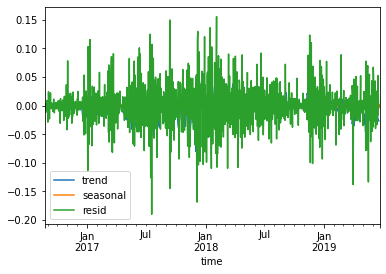

In [40]:
decomposition.iloc[:,1:].plot()

### No seasonality evident

### Plotting some of the predictors vs returns

In [41]:
train.columns

Index(['time', 'low', 'high', 'open', 'close', 'volume', 'fwd_log_ret',
       'fwd_ret', 'fwd_pct_chg', 'fwd_close_positive', 'pct_chg',
       'log_ret_lag_1', 'log_ret_lag_2', 'log_ret_lag_3', 'log_ret_lag_4',
       'log_ret_lag_5', 'log_ret_lag_6', 'log_ret_lag_7', 'RR', 'sigma_lag_1',
       'sigma_lag_2', 'sigma_lag_3', 'sigma_lag_4', 'sigma_lag_5',
       'sigma_lag_6', 'sigma_lag_7', 'day_name_Friday', 'day_name_Monday',
       'day_name_Saturday', 'day_name_Sunday', 'day_name_Thursday',
       'day_name_Tuesday', 'day_name_Wednesday'],
      dtype='object')

<AxesSubplot:xlabel='sigma_lag_7', ylabel='fwd_log_ret'>

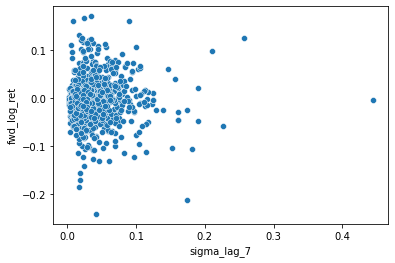

In [42]:
sns.scatterplot(train.sigma_lag_7, train.fwd_log_ret)

# Modeling
- Will start with ARIMA
- After ARIMA will try regression and classification models

### Arima
- Will set up a grid search for best parameters to use
- Based on https://machinelearningmastery.com/grid-search-arima-hyperparameters-with-python/
- No validate dataset needed as ARIMA will perform one day prediction and then will be retrained for next day

In [71]:
def evaluate_arima_model(train, test, target, arima_order):
    """ Evaluates an ARIMA model based on arima_order argument, train set, test set, and target. 
    Outputs error and predictions for every  timestep in test"""
    train_target = train[target]
    test_target = test[target]
    history = [x for x in train_target]

    # Make predictions
    predictions = []
    for t in range(len(test_target)):
        print(f"\tTesting {arima_order} {t}/{len(test_target)}", end="\r")
        model = ARIMA(history, order = arima_order)
        model_fit = model.fit()
        # Forecast returns forecast value, standard error, and confidence interval - only need forecast value ([0])
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        # Adds the latest test value to history so it can be used to train
        history.append(test_target[t])
    error = mean_squared_error(test_target, predictions)
    print("\n")
    return error, test_target, predictions

In [75]:
def evaluate_models(train, test, target, p_values, d_values, q_values):
    mses=[]
    prediction_list=[]
    actual_test = []
    orders = []
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                orders.append(order)
                try:
                    mse, test_target, predictions = evaluate_arima_model(train, test, target, order)
                    mses.append(mse)
                    prediction_list.append(predictions)
                    actual_test.append(test_target)
                except KeyboardInterrupt:
                    print("Keyboard interrupt")
                    raise
                except:
                    print(f"{order} didn't work, continuing with next order")
                    continue
    results_df = pd.DataFrame.from_records(orders, columns = ['p','d','q'])
    results_df["mse"] = mses
    results_df["test_predictions"] = prediction_list
    results_df["test_actual"] = actual_test
    return results_df

In [77]:
p_values = [1]
d_values = [3]
q_values = [3]
results_df = evaluate_models(train.iloc[:980], train.iloc[980:], 'fwd_log_ret', p_values, d_values, q_values)

	Testing (1, 3, 3) 52/53



In [80]:
results_df

,p,d,q,mse,test_predictions,test_actual
0,1,3,3,0.003792,"[-0.004839391428457039, -0.006010558463146194,...",time 2019-05-01 -0.012858 2019-05-02 -0.04...


In [89]:
real = results_df.test_actual[0]
predictions = results_df.test_predictions[0]

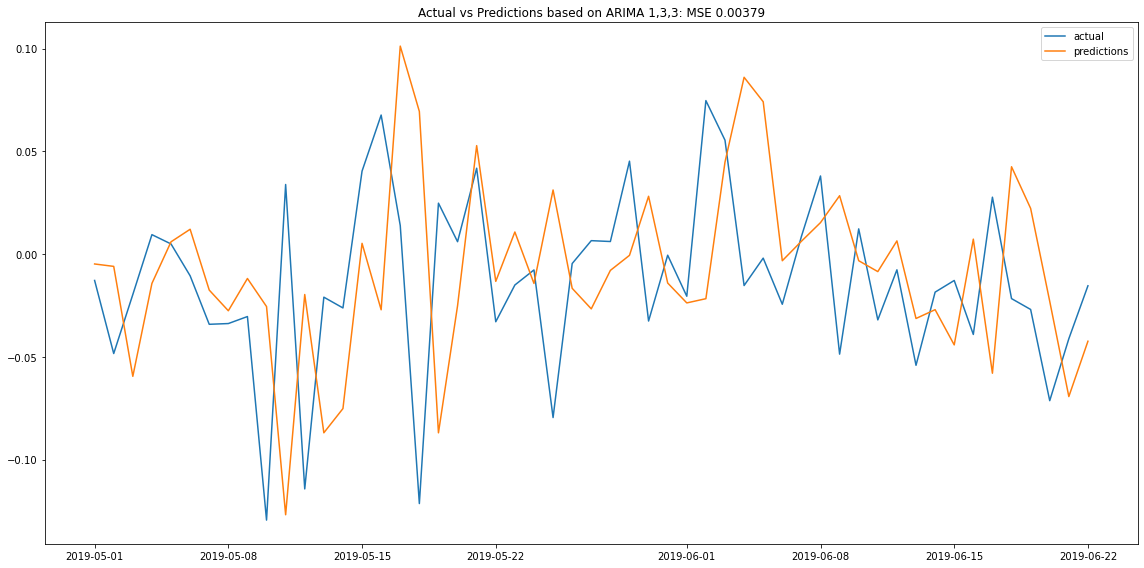

In [103]:
plt.figure(figsize=(16,8))
plt.plot(train.iloc[980:].fwd_log_ret, label = "actual")
plt.plot(train.iloc[980:].index, predictions, label = "predictions")
plt.title(f"Actual vs Predictions based on ARIMA 1,3,3: MSE {results_df.mse[0]:.5f}")
plt.legend()
plt.tight_layout()

### Best ARIMA parameters based on gridsearch of:
p_values = [0,1,2]
d_values = [0,1,2]
q_values = [0,1,2]
- (p,d,q) = (1,2,2) -> MSE of 0.001813
- 2 is top q and d value
- 1 and 0 top p value

## Evaluate regression models

In [120]:
train.columns

Index(['time', 'low', 'high', 'open', 'close', 'volume', 'fwd_log_ret',
       'fwd_ret', 'fwd_pct_chg', 'fwd_close_positive', 'pct_chg',
       'log_ret_lag_1', 'log_ret_lag_2', 'log_ret_lag_3', 'log_ret_lag_4',
       'log_ret_lag_5', 'log_ret_lag_6', 'log_ret_lag_7', 'RR', 'sigma_lag_1',
       'sigma_lag_2', 'sigma_lag_3', 'sigma_lag_4', 'sigma_lag_5',
       'sigma_lag_6', 'sigma_lag_7', 'day_name_Friday', 'day_name_Monday',
       'day_name_Saturday', 'day_name_Sunday', 'day_name_Thursday',
       'day_name_Tuesday', 'day_name_Wednesday'],
      dtype='object')

In [153]:
features_to_use = ['log_ret_lag_1', 'log_ret_lag_2', 'log_ret_lag_3', 'log_ret_lag_4',
       'log_ret_lag_5', 'log_ret_lag_6', 'log_ret_lag_7', 'RR', 'sigma_lag_1',
       'sigma_lag_2', 'sigma_lag_3', 'sigma_lag_4', 'sigma_lag_5',
       'sigma_lag_6', 'sigma_lag_7', 'day_name_Friday', 'day_name_Monday',
       'day_name_Saturday', 'day_name_Sunday', 'day_name_Thursday',
       'day_name_Tuesday', 'day_name_Wednesday']
features_to_scale = ['log_ret_lag_1', 'log_ret_lag_2', 'log_ret_lag_3', 'log_ret_lag_4',
       'log_ret_lag_5', 'log_ret_lag_6', 'log_ret_lag_7', 'RR', 'sigma_lag_1',
       'sigma_lag_2', 'sigma_lag_3', 'sigma_lag_4', 'sigma_lag_5',
       'sigma_lag_6', 'sigma_lag_7']


In [154]:
# def evaluate_regression_model(train, validate, test, target, features_to_use, model):



In [155]:
model = LinearRegression()
target = 'fwd_log_ret'

In [156]:
# Segment out features into individual dataframes
X_train = train[features_to_use]
X_validate = validate[features_to_use]
X_test = test[features_to_use]

# Segment out target into individual dataframe
y_train = train[target]
y_validate = validate[target]
y_test = test[target]

# Will scale features using StandardScaler as sigmas are orders of magnitude different from log_ret
scaler = MinMaxScaler()

# Fit scaler to train. Transform validate and test based on fitted scaler
X_train_scaled = pd.concat([X_train.drop(columns = features_to_scale),
                            pd.DataFrame(data = scaler.fit_transform(X_train[features_to_scale]), 
                                         columns = features_to_scale, index = X_train.index)], 
                           axis=1)
X_validate_scaled = pd.concat([X_validate.drop(columns = features_to_scale),
                            pd.DataFrame(data = scaler.transform(X_validate[features_to_scale]), 
                                         columns = features_to_scale, index = X_validate.index)], 
                           axis=1)
X_validate_scaled = pd.concat([X_test.drop(columns = features_to_scale),
                            pd.DataFrame(data = scaler.transform(X_test[features_to_scale]), 
                                         columns = features_to_scale, index = X_test.index)], 
                           axis=1)

# Feature selection using model (argument)

lm = model

rfe = RFE(lm, n_features_to_select=1)

rfe.fit(X_train_scaled, y_train)

# Get mask of the columns selected
feature_mask = rfe.support_

# Get list of column names
rfe_feature = X_train_scaled.iloc[:,feature_mask].columns.tolist()

In [157]:
# view list of columns and their ranking

# get the ranks
var_ranks = rfe.ranking_
# get the variable names
var_names = X_train_scaled.columns.tolist()
# combine ranks and names into a df for clean viewing
rfe_ranks_df = pd.DataFrame({'Var': var_names, 'Rank': var_ranks})
# sort the df by rank
rfe_ranks_df.sort_values('Rank')


,Var,Rank
5,day_name_Tuesday,1
2,day_name_Saturday,2
6,day_name_Wednesday,3
4,day_name_Thursday,4
3,day_name_Sunday,5
1,day_name_Monday,6
0,day_name_Friday,7
14,RR,8
15,sigma_lag_1,9
12,log_ret_lag_6,10


In [ ]:
# Make predictions
predictions = []
for t in range(len(test_target)):
    print(f"\tTesting {arima_order} {t}/{len(test_target)}", end="\r")
    model = model
    model_fit = model.fit()
    yhat = model_fit.forecast()[0]
    predictions.append(yhat)
    # Adds the latest test value to history so it can be used to train
    history.append(test_target[t])
error = mean_squared_error(test_target, predictions)
print("\n")
    # return error

In [ ]:
# We need y_train and y_validate to be dataframes to append the new columns with predicted values. 
y_train = pd.DataFrame(y_train)
y_validate = pd.DataFrame(y_validate)

# 1. Predict G3_pred_mean
G3_pred_mean = y_train['G3'].mean()
y_train['G3_pred_mean'] = G3_pred_mean
y_validate['G3_pred_mean'] = G3_pred_mean

# 2. compute G3_pred_median
G3_pred_median = y_train['G3'].median()
y_train['G3_pred_median'] = G3_pred_median
y_validate['G3_pred_median'] = G3_pred_median

# 3. RMSE of G3_pred_mean
rmse_train = mean_squared_error(y_train.G3, y_train.G3_pred_mean)**(1/2)
rmse_validate = mean_squared_error(y_validate.G3, y_validate.G3_pred_mean)**(1/2)

print("RMSE using Mean\nTrain/In-Sample: ", round(rmse_train, 2), 
      "\nValidate/Out-of-Sample: ", round(rmse_validate, 2))

# 4. RMSE of G3_pred_median
rmse_train = mean_squared_error(y_train.G3, y_train.G3_pred_median)**(1/2)
rmse_validate = mean_squared_error(y_validate.G3, y_validate.G3_pred_median)**(1/2)

print("RMSE using Median\nTrain/In-Sample: ", round(rmse_train, 2), 
      "\nValidate/Out-of-Sample: ", round(rmse_validate, 2))
